<a href="https://colab.research.google.com/github/hyunseoki/GAN/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Config:
    latent_dim = 100
    lr = 2e-4
    batch_size = 128
    num_epochs = 200

h, w = 64, 64
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = transforms.Compose([
                    transforms.Resize((h,w)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
])

In [3]:
train_data_set = datasets.STL10('./data', split='train', download=True, transform=transform)
train_data_loader = DataLoader(train_data_set, batch_size=Config.batch_size, shuffle=True)

100%|██████████| 2640397119/2640397119 [02:44<00:00, 16087676.98it/s]


Extracting ./data/stl10_binary.tar.gz to ./data


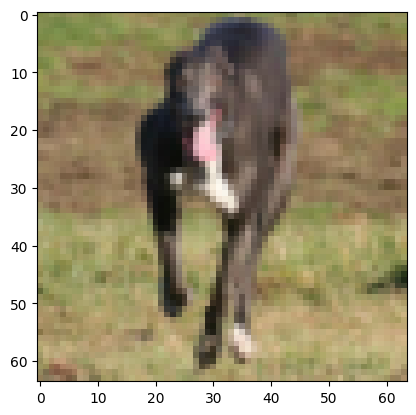

In [4]:
img, label = train_data_set[1]
plt.imshow(img.permute(1,2,0)*0.5 + 0.5)
plt.show()

In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, in_dim=3, n_filters=64):
        super().__init__()

        def block(in_dim, out_dim, normalize=True, **kwargs):
            layers = [nn.ConvTranspose2d(
                in_channels=in_dim,
                out_channels=out_dim,
                bias=False,
                **kwargs
            )]
            if normalize:
                layers.append(nn.BatchNorm2d(out_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers

        self.model = nn.Sequential(
            *block(in_dim=latent_dim, out_dim=n_filters * 8, kernel_size=4, stride=1), ## (b, 512, 4, 4)
            *block(in_dim=n_filters * 8, out_dim=n_filters * 4, kernel_size=4, stride=2, padding=1), ## (b, 256, 8, 8)
            *block(in_dim=n_filters * 4, out_dim=n_filters * 2, kernel_size=4, stride=2, padding=1), ## (b, 128, 16, 16)
            *block(in_dim=n_filters * 2, out_dim=n_filters * 1, kernel_size=4, stride=2, padding=1), ## (b, 64, 16, 16)
            nn.ConvTranspose2d(in_channels=n_filters, out_channels=in_dim, kernel_size=4, stride=2, padding=1), ## (b, 3, 64, 64)
            nn.Tanh()
        )

    def forward(self, z):
        z = z.unsqueeze(-1).unsqueeze(-1)
        img = self.model(z)

        return img
        

class Discriminator(nn.Module):
    def __init__(self, in_dim=3, n_filters=64):
        super().__init__()

        def block(in_dim, out_dim, normalize=True, **kwargs):
            layers = [nn.Conv2d(
                in_channels=in_dim,
                out_channels=out_dim,
                bias=False,
                **kwargs
            )]
            if normalize:
                layers.append(nn.BatchNorm2d(out_dim))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers

        self.model = nn.Sequential(
            *block(in_dim=in_dim, out_dim=n_filters, kernel_size=4, stride=2, padding=1), ## (b, n_filters, 32, 32)
            *block(in_dim=n_filters, out_dim=n_filters*2, kernel_size=4, stride=2, padding=1), ## (b, n_filters*2, 16, 16)
            *block(in_dim=n_filters*2, out_dim=n_filters*4, kernel_size=4, stride=2, padding=1), ## (b, n_filters*4, 8, 8)
            *block(in_dim=n_filters*4, out_dim=n_filters*8, kernel_size=4, stride=2, padding=1), ## (b, n_filters*8, 4, 4)
            nn.Conv2d(in_channels=n_filters*8, out_channels=1, kernel_size=4, stride=1, padding=0), ## (b, 1, 1, 1)
            nn.Sigmoid(),
        )

    def forward(self, input):
        out = self.model(input).view(input.size(0), -1)

        return out

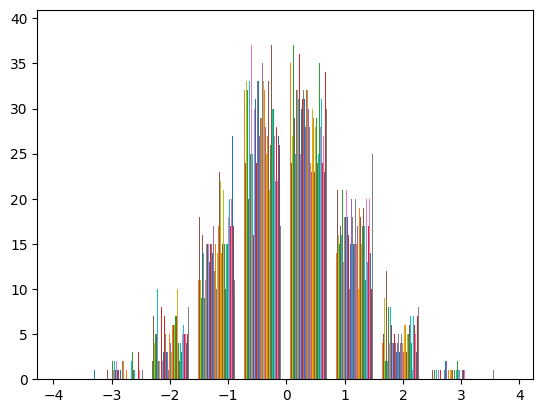

In [10]:
z = torch.normal(mean=0, std=1, size=(128, Config.latent_dim))
plt.hist(z)
plt.show()

In [18]:
generator = Generator(latent_dim=100)
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=Config.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=Config.lr, betas=(0.5, 0.999))

loss_history={'gen':[],
              'dis':[]}

In [21]:
generator.train()
discriminator.train()

start_time = time.time()

for epoch in range(Config.num_epochs):
    for i, (imgs, _) in enumerate(train_data_loader):
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0
        
        ''' Generator ''' 
        optimizer_G.zero_grad()      

        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], Config.latent_dim)).cuda()
        generated_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(generated_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        ''' Discriminator ''' 
        optimizer_D.zero_grad()

        real_imgs = imgs.cuda()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()

        loss_history['gen'].append(g_loss.item())
        loss_history['dis'].append(d_loss.item())

    print(f"[Epoch {epoch}/{Config.num_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.265120] [G loss: 7.415332] [Elapsed time: 8.86s]
[Epoch 1/200] [D loss: 0.422523] [G loss: 1.966172] [Elapsed time: 19.17s]
[Epoch 2/200] [D loss: 0.229153] [G loss: 3.138129] [Elapsed time: 27.35s]
[Epoch 3/200] [D loss: 0.333802] [G loss: 2.203599] [Elapsed time: 36.09s]
[Epoch 4/200] [D loss: 0.691010] [G loss: 2.300021] [Elapsed time: 44.79s]
[Epoch 5/200] [D loss: 0.558873] [G loss: 2.201177] [Elapsed time: 54.07s]
[Epoch 6/200] [D loss: 0.768489] [G loss: 1.830162] [Elapsed time: 63.22s]
[Epoch 7/200] [D loss: 0.224530] [G loss: 3.054250] [Elapsed time: 72.38s]
[Epoch 8/200] [D loss: 0.262134] [G loss: 2.453140] [Elapsed time: 82.14s]
[Epoch 9/200] [D loss: 3.263079] [G loss: 4.842504] [Elapsed time: 91.81s]
[Epoch 10/200] [D loss: 0.316095] [G loss: 1.639782] [Elapsed time: 100.48s]
[Epoch 11/200] [D loss: 0.729286] [G loss: 1.310633] [Elapsed time: 109.92s]
[Epoch 12/200] [D loss: 0.629410] [G loss: 2.092211] [Elapsed time: 118.47s]
[Epoch 13/200] [D lo

KeyboardInterrupt: ignored

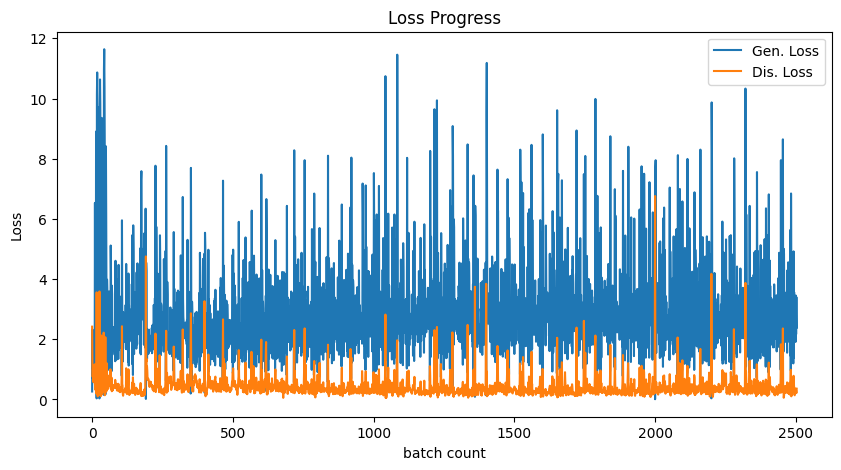

In [22]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# evalutaion mode
generator.eval()

# fake image 생성
with torch.no_grad():
    z = torch.normal(mean=0, std=1, size=(16, Config.latent_dim)).cuda()
    img_fake = generator(z).detach().cpu()
print(img_fake.shape)

torch.Size([16, 3, 64, 64])


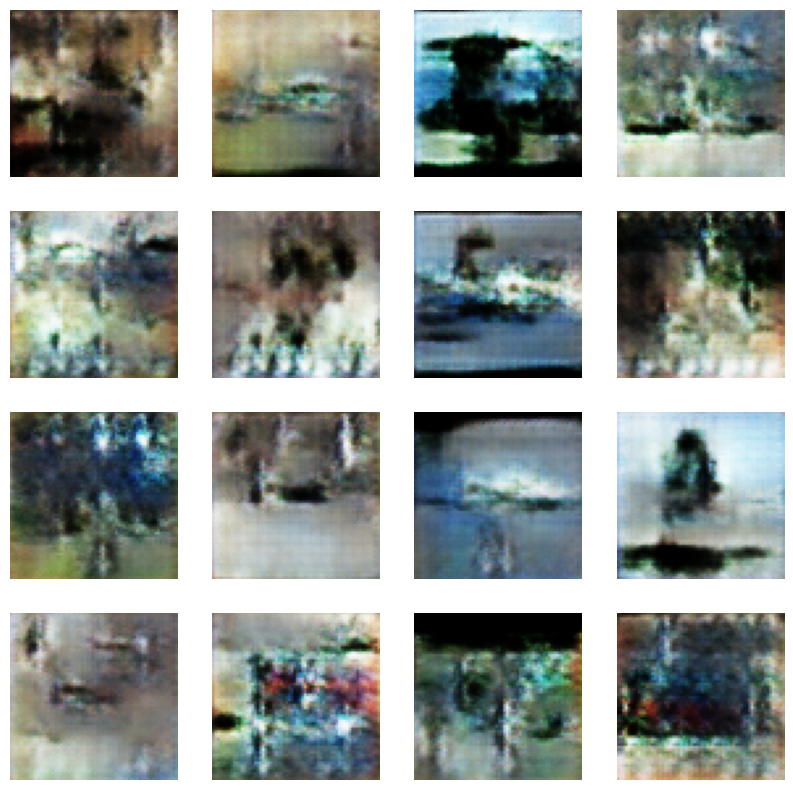

In [28]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')